<div style='font-size:100%;'>
    <a id='import'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Importing the necessary libraries</center>
    </h1>
</div>

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

<div style='font-size:100%;'>
    <a id='methodology'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Proposed Methodology</center>
    </h1>
</div>

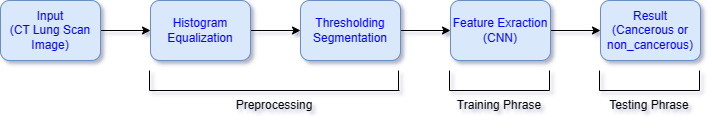

In [8]:
Image(filename='./methodology.png')

<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Data Pre-processing</center>
    </h1>
</div>

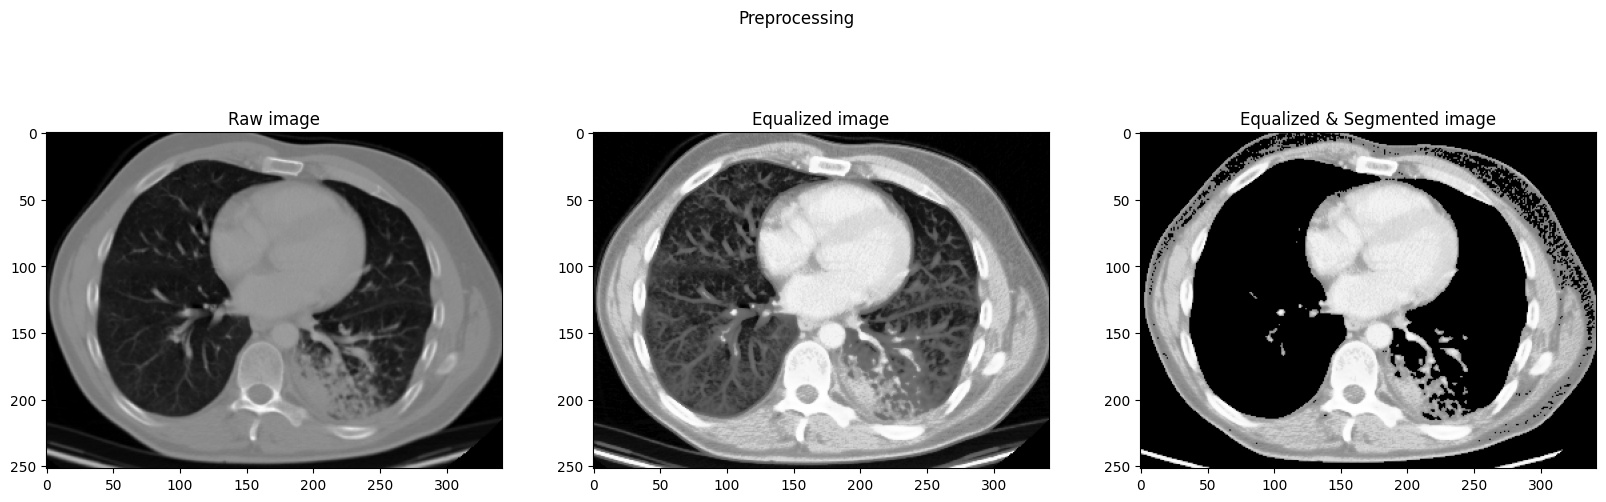

In [3]:
img = cv2.imread('rawData/squamous.cell.carcinoma/squamous.cell.carcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [4]:
print(os.getcwd(), os.listdir())
DIR = 'rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = 'data'

d:\code\AI\Lung cancer\New folder (2)\lung-cancer-detection-main ['CNN.png', 'data', 'eval.txt', 'methodology.jpeg', 'notebook.ipynb', 'processedData', 'rawData']


In [5]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('rawData/normal', 'data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData/adenocarcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/large.cell.carcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/squamous.cell.carcinoma', 'data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at data


<div style='font-size:100%;'>
    <a id='comparison'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

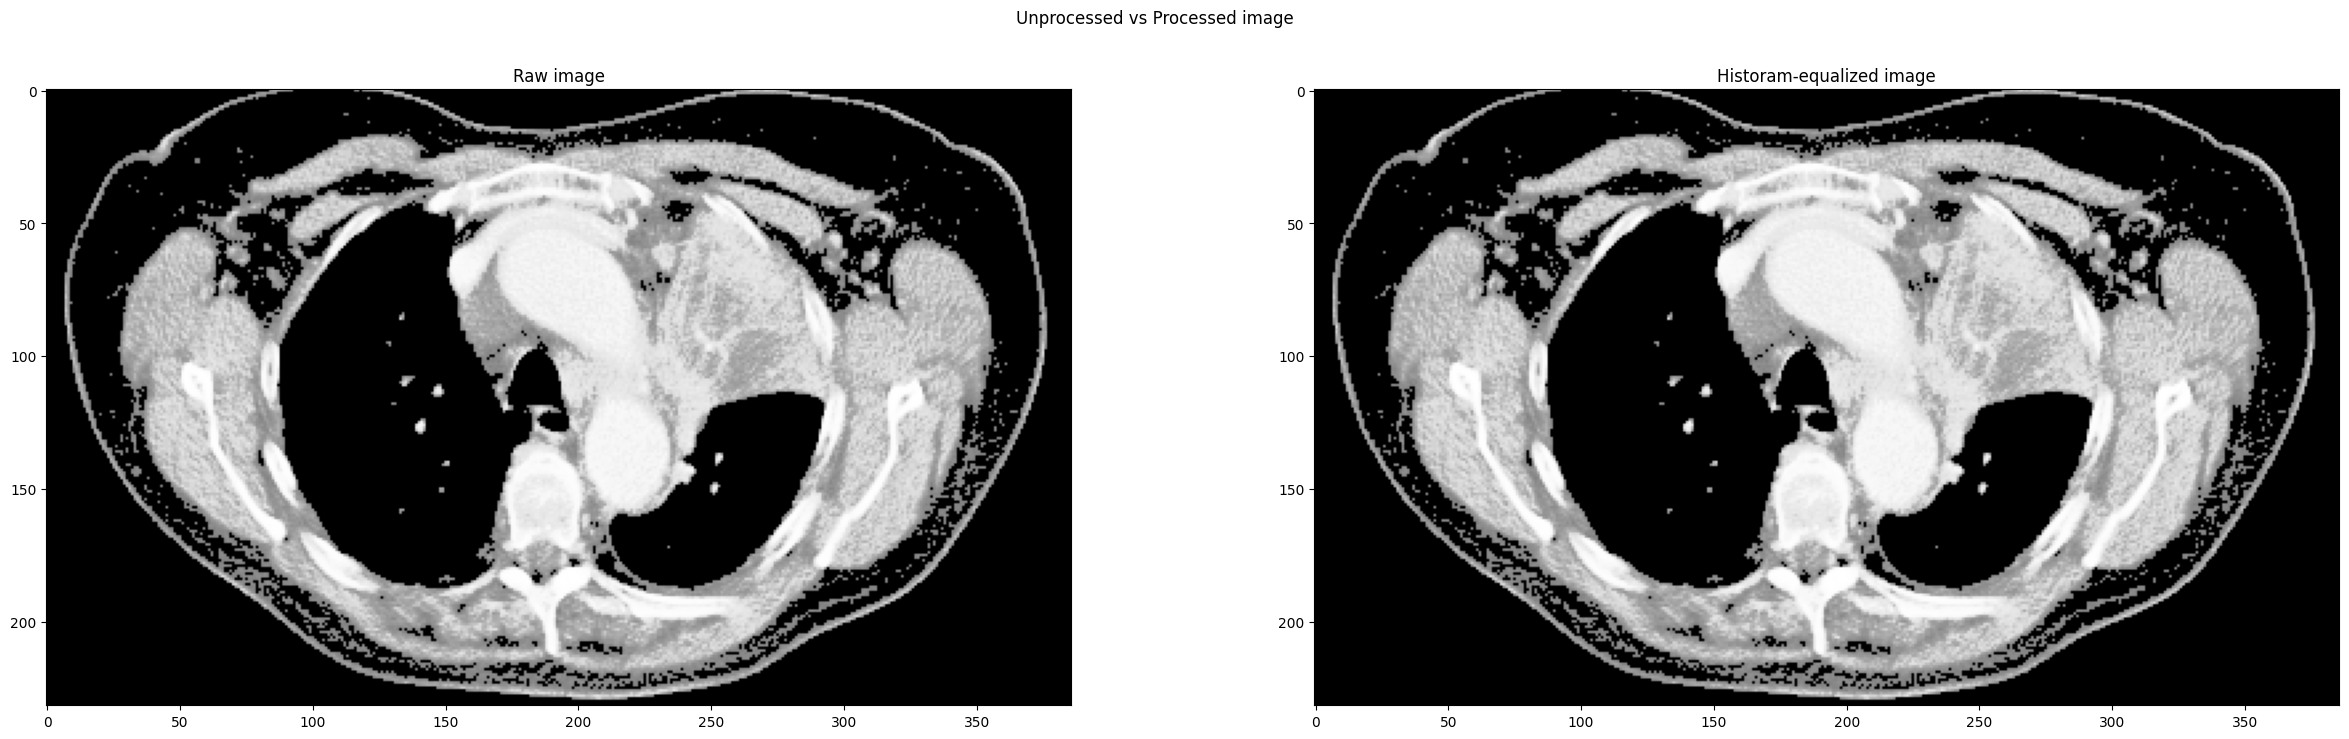

In [6]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='split'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [7]:
FINAL_DIR = 'processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2))

In [9]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [10]:
train_dataset  = train_datagen.flow_from_directory(directory = 'processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [11]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [12]:
test_dataset = test_datagen.flow_from_directory(directory = 'processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='nn'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [13]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()


<h1 align="center" ><a id='cnn'><b>CNN<b></a></h1>

In [ ]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

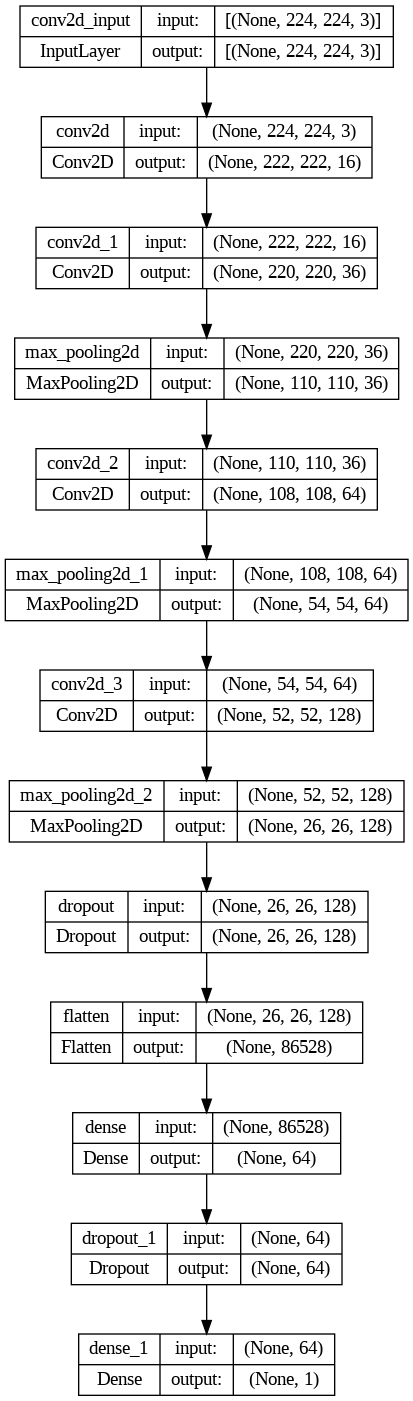

In [ ]:
tf.keras.utils.plot_model(CNN, to_file='CNN.png', show_shapes=True,show_layer_names=True)
Image(filename='CNN.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6349 - Accuracy: 0.7568 - Precision: 0.2619 - Recall: 0.0733 - AUC: 0.5253 - F1: 0.0532

22/22 [==============================] - 29s 761ms/step - loss: 0.6349 - Accuracy: 0.7568 - Precision: 0.2619 - Recall: 0.0733 - AUC: 0.5253 - F1: 0.0532 - val_loss: 0.5140 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.6016 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4847 - Accuracy: 0.7868 - Precision: 1.0000 - Recall: 0.0067 - AUC: 0.6875 - F1: 0.0152

22/22 [==============================] - 14s 625ms/step - loss: 0.4847 - Accuracy: 0.7868 - Precision: 1.0000 - Recall: 0.0067 - AUC: 0.6875 - F1: 0.0152 - val_loss: 0.3929 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8684 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4724 - Accuracy: 0.7940 - Precision: 0.5500 - Recall: 0.2200 - AUC: 0.7197 - F1: 0.3050

22/22 [==============================] - 13s 592ms/step - loss: 0.4724 - Accuracy: 0.7940 - Precision: 0.5500 - Recall: 0.2200 - AUC: 0.7197 - F1: 0.3050 - val_loss: 0.3706 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.9017 - val_F1: 0.1125 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4588 - Accuracy: 0.7883 - Precision: 0.6667 - Recall: 0.0267 - AUC: 0.7386 - F1: 0.0408

22/22 [==============================] - 14s 640ms/step - loss: 0.4588 - Accuracy: 0.7883 - Precision: 0.6667 - Recall: 0.0267 - AUC: 0.7386 - F1: 0.0408 - val_loss: 0.3578 - val_Accuracy: 0.8990 - val_Precision: 1.0000 - val_Recall: 0.5238 - val_AUC: 0.9399 - val_F1: 0.7625 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3937 - Accuracy: 0.8340 - Precision: 0.7576 - Recall: 0.3333 - AUC: 0.8355 - F1: 0.4139

22/22 [==============================] - 14s 634ms/step - loss: 0.3937 - Accuracy: 0.8340 - Precision: 0.7576 - Recall: 0.3333 - AUC: 0.8355 - F1: 0.4139 - val_loss: 0.2151 - val_Accuracy: 0.9394 - val_Precision: 0.8571 - val_Recall: 0.8571 - val_AUC: 0.9786 - val_F1: 0.6212 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.4073 - Accuracy: 0.8298 - Precision: 0.6824 - Recall: 0.3867 - AUC: 0.8156 - F1: 0.4539

22/22 [==============================] - 14s 624ms/step - loss: 0.4073 - Accuracy: 0.8298 - Precision: 0.6824 - Recall: 0.3867 - AUC: 0.8156 - F1: 0.4539 - val_loss: 0.2384 - val_Accuracy: 0.8889 - val_Precision: 0.8571 - val_Recall: 0.5714 - val_AUC: 0.9747 - val_F1: 0.5205 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3464 - Accuracy: 0.8684 - Precision: 0.8152 - Recall: 0.5000 - AUC: 0.8718 - F1: 0.5673

22/22 [==============================] - 14s 638ms/step - loss: 0.3464 - Accuracy: 0.8684 - Precision: 0.8152 - Recall: 0.5000 - AUC: 0.8718 - F1: 0.5673 - val_loss: 0.1886 - val_Accuracy: 0.9495 - val_Precision: 0.8077 - val_Recall: 1.0000 - val_AUC: 0.9939 - val_F1: 0.6853 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.3021 - Accuracy: 0.8856 - Precision: 0.8182 - Recall: 0.6000 - AUC: 0.9041 - F1: 0.6689

22/22 [==============================] - 14s 643ms/step - loss: 0.3021 - Accuracy: 0.8856 - Precision: 0.8182 - Recall: 0.6000 - AUC: 0.9041 - F1: 0.6689 - val_loss: 0.4481 - val_Accuracy: 0.7778 - val_Precision: 0.4884 - val_Recall: 1.0000 - val_AUC: 0.9792 - val_F1: 0.4886 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.3341 - Accuracy: 0.8755 - Precision: 0.7788 - Recall: 0.5867 - AUC: 0.8816 - F1: 0.6481

22/22 [==============================] - 14s 627ms/step - loss: 0.3341 - Accuracy: 0.8755 - Precision: 0.7788 - Recall: 0.5867 - AUC: 0.8816 - F1: 0.6481 - val_loss: 0.8078 - val_Accuracy: 0.5354 - val_Precision: 0.3134 - val_Recall: 1.0000 - val_AUC: 0.9496 - val_F1: 0.5437 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2959 - Accuracy: 0.8827 - Precision: 0.7982 - Recall: 0.6067 - AUC: 0.9100 - F1: 0.6584
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 14s 636ms/step - loss: 0.2959 - Accuracy: 0.8827 - Precision: 0.7982 - Recall: 0.6067 - AUC: 0.9100 - F1: 0.6584 - val_loss: 0.3921 - val_Accuracy: 0.7879 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_AUC: 0.9875 - val_F1: 0.5039 - lr: 0.0010
Epoch 10: early stopping


In [ ]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 276ms/step - loss: 0.3180 - Accuracy: 0.8564 - Precision: 0.6087 - Recall: 0.9545 - AUC: 0.9662 - F1: 0.7329


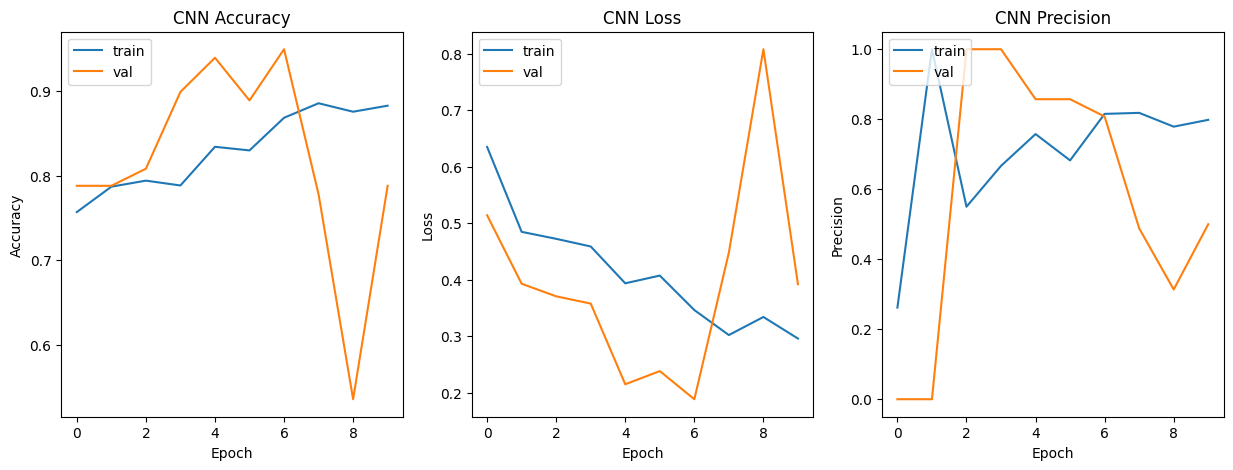

In [ ]:
plot_history(CNN_history, 'CNN')

<div style='font-size:100%;'>
    <a id='example'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Example: Prediction vs Truth </center>
    </h1>
</div></center>

1/1 [==============================] - 0s 18ms/step


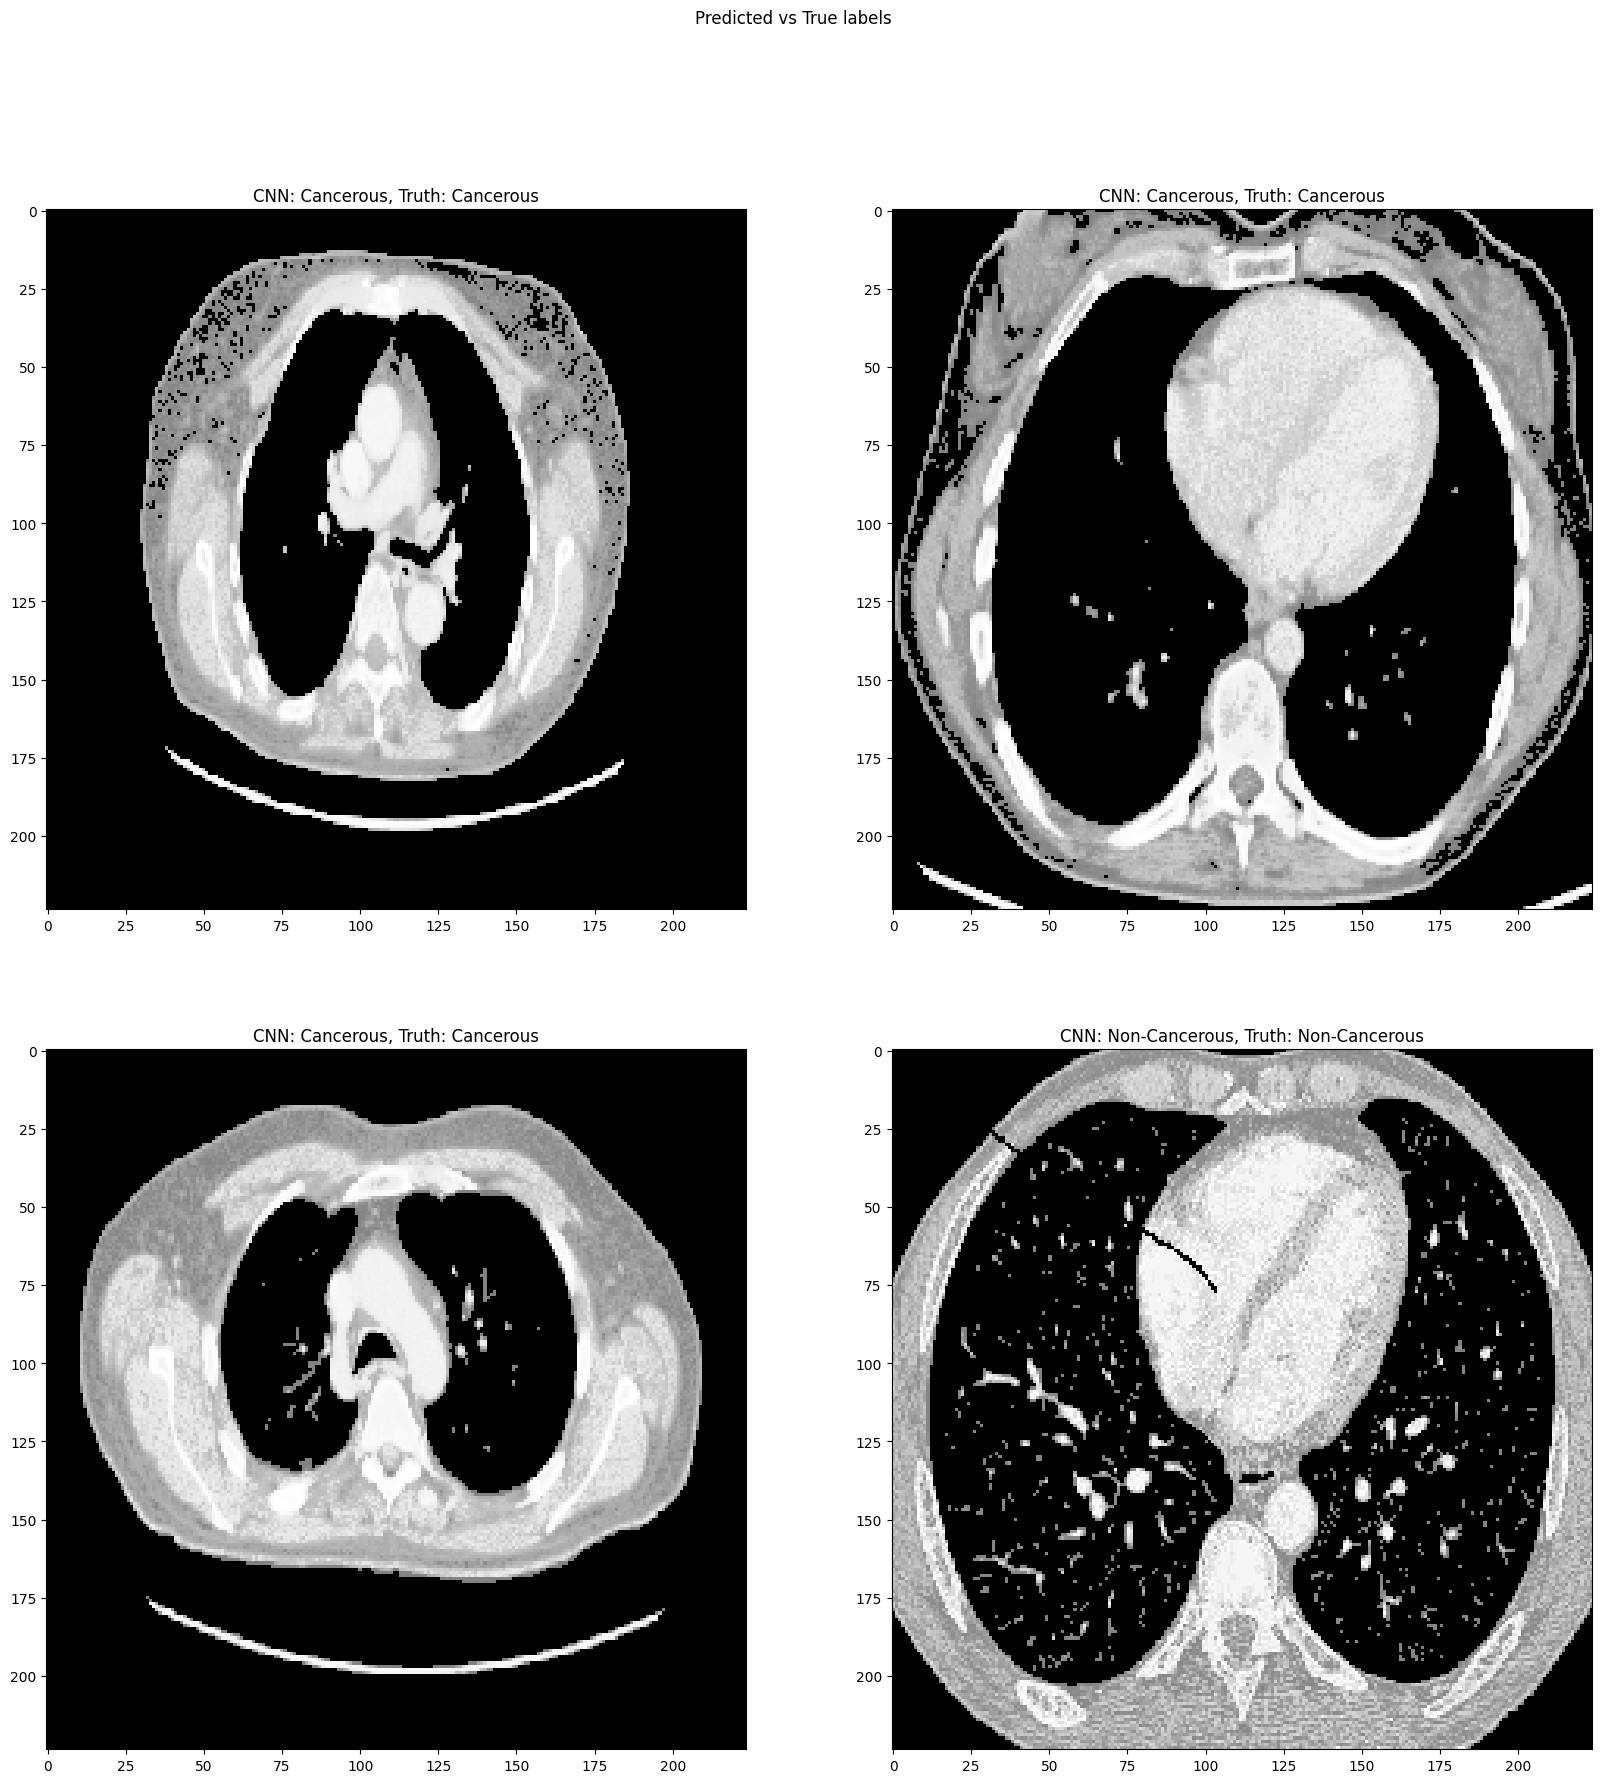

In [ ]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # vgg19Pred = 0 if VGG19.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # xceptionPred = 0 if Xception.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # inceptionv3Pred = 0 if InceptionV3.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # resnet50Pred = 0 if ResNet50.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  # return f'CNN: {label_dict[cnnPred]}, VGG16: {label_dict[vgg16Pred]}\nVGG19: {label_dict[vgg19Pred]}, MobileNet: {label_dict[mobilenetPred]}\nResNet50: {label_dict[resnet50Pred]}, Xception: {label_dict[xceptionPred]}\nInceptionV3: {label_dict[inceptionv3Pred]}, Truth: {label_dict[int(batch[1][i])]}'
  return f'CNN: {label_dict[cnnPred]}, Truth: {label_dict[int(batch[1][i])]}'

plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()
